In [9]:
import pandas as pd
import numpy as np

# Read files

In [10]:
# Central results

central_results = pd.read_csv('after/all_corrected_R_expr.tsv', sep='\t', index_col=0)
print(f"Samples: {central_results.shape[1]}, Genes: {central_results.shape[0]}")

Samples: 309, Genes: 13237


In [11]:
# FedApp results
expr_files = [
    'after/fed_res/0_bayes_data.csv',
    'after/fed_res/1_bayes_data.csv',
    'after/fed_res/2_bayes_data.csv',
    'after/fed_res/3_bayes_data.csv',
    'after/fed_res/4_bayes_data.csv',
    'after/fed_res/5_bayes_data.csv'
]

expr_dfs = [pd.read_csv(file, sep=',', index_col=0) for file in expr_files]

if expr_dfs:  # Check if expr_dfs is not empty
    fedapp_results = pd.concat(expr_dfs, axis=1, join='inner')  # Concatenate based on index
else:
    fedapp_results = pd.DataFrame()  # Create an empty DataFrame if no files are found

fedapp_results = fedapp_results.loc[central_results.index, central_results.columns]  # Align the indices and columns
print(f"Samples: {fedapp_results.shape[1]}, Genes: {fedapp_results.shape[0]}")

Samples: 309, Genes: 13237


In [12]:
design = pd.read_csv('before/all_design.tsv', sep='\t', index_col=0)
design = design.loc[central_results.columns, :]

print(f"Samples: {design.shape[0]}, Covariates: {design.shape[1]}")
design.head()

Samples: 309, Covariates: 2


,Tumor,batch
GSM139435,1,4
GSM139436,1,4
GSM139437,1,4
GSM139438,1,4
GSM139439,1,4


# Compare

In [13]:
# min, maen, max difference between each pair of results
diff = central_results - fedapp_results
abs_diff = np.abs(diff)
min_diff = abs_diff.min().min()
max_diff = abs_diff.max().max()
mean_diff = abs_diff.mean().mean()

print(f"Min difference: {min_diff}, Max difference: {max_diff}, Mean difference: {mean_diff}")

Min difference: 4.183218393905008e-08, Max difference: 4.206383584268194, Mean difference: 0.8370204074985397


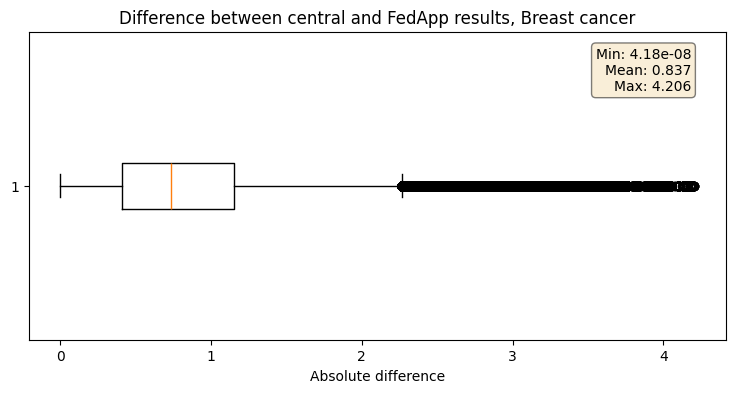

In [14]:
import matplotlib.pyplot as plt

# Calculate statistics
min_val = abs_diff.values.flatten().min()
max_val = abs_diff.values.flatten().max()
mean_val = abs_diff.values.flatten().mean()

# Create a horizontal boxplot
plt.figure(figsize=(9, 4))
plt.boxplot(abs_diff.values.flatten(), vert=False)
plt.title('Difference between central and FedApp results, Breast cancer')
plt.xlabel('Absolute difference')

# Adding text box for min, max, and mean
textstr = f'Min: {min_val:.2e}\nMean: {mean_val:.3f}\nMax: {max_val:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, 
               fontsize=10, verticalalignment='top', horizontalalignment='right', 
               bbox=props)

plt.show()


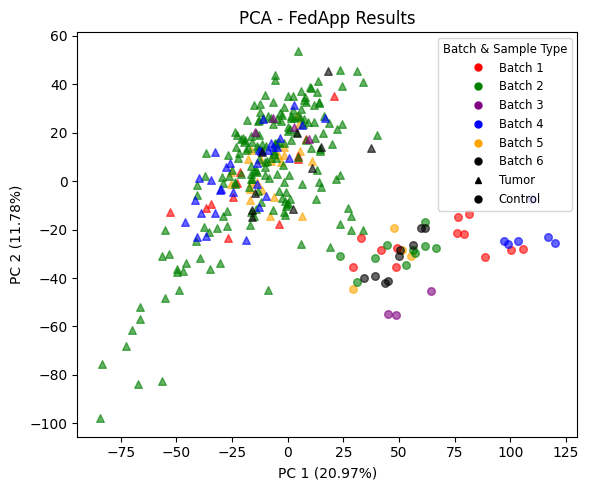

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fedapp_results.T)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=fedapp_results.columns)
pca_df['batch'] = design['batch'].values
pca_df['Tumor'] = design['Tumor'].values

# Define colors for different batches
batch_colors = {0: 'red', 1: 'green', 2: 'purple', 3: 'blue', 4: 'orange', 5: 'black'}

# Define markers for different luminal values (Lum and Basal)
lum_markers = {1: '^', 0: 'o'}  # Using a triangle for Luminal and a circle for Basal

# Plot PCA
plt.figure(figsize=(6, 5))
for lum_value in pca_df['Tumor'].unique():
    for batch_value in pca_df['batch'].unique():
        indices = (pca_df['Tumor'] == lum_value) & (pca_df['batch'] == batch_value)
        plt.scatter(pca_df.loc[indices, 'PC1'], 
                    pca_df.loc[indices, 'PC2'], 
                    color=batch_colors[batch_value], 
                    marker=lum_markers[lum_value], 
                    s=30,  # Adjust marker size
                    alpha=0.6,  # Adjust transparency
                    label=f'Batch {batch_value + 1}, {"Tumor" if lum_value == 1 else "Control"}')

# Custom legend
import matplotlib.lines as mlines

# Create handles for the legend with specific colors for batches and markers for Luminal/Basal
batch_1 = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='Batch 1')
batch_2 = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Batch 2')
batch_3 = mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=5, label='Batch 3')
batch_4 = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='Batch 4')
batch_5 = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Batch 5')
batch_6 = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Batch 6')

lum = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=5, label='Tumor')
basal = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Control')

# Add legend
plt.legend(handles=[batch_1, batch_2, batch_3,
                    batch_4, batch_5, batch_6,
                    lum, basal], 
                    title='Batch & Sample Type',
                    loc='upper right',
                    fontsize='small',
                    title_fontsize='small')

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# add PC values to the axis labels
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA - FedApp Results')

plt.tight_layout()

plt.show()


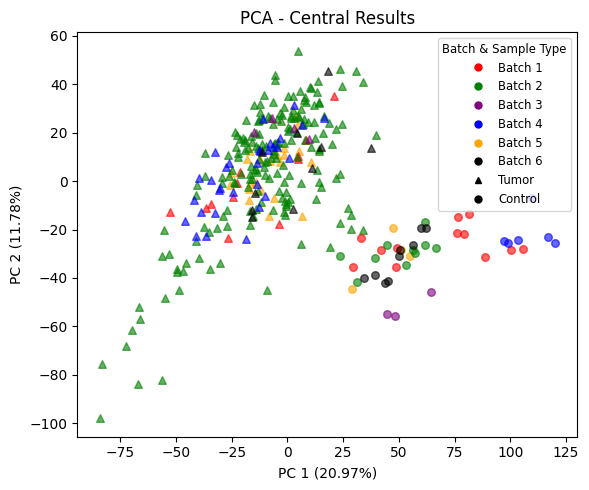

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(central_results.T)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=fedapp_results.columns)
pca_df['batch'] = design['batch'].values
pca_df['Tumor'] = design['Tumor'].values

# Define colors for different batches
batch_colors = {0: 'red', 1: 'green', 2: 'purple', 3: 'blue', 4: 'orange', 5: 'black'}

# Define markers for different luminal values (Lum and Basal)
lum_markers = {1: '^', 0: 'o'}  # Using a triangle for Luminal and a circle for Basal

# Plot PCA
plt.figure(figsize=(6, 5))
for lum_value in pca_df['Tumor'].unique():
    for batch_value in pca_df['batch'].unique():
        indices = (pca_df['Tumor'] == lum_value) & (pca_df['batch'] == batch_value)
        plt.scatter(pca_df.loc[indices, 'PC1'], 
                    pca_df.loc[indices, 'PC2'], 
                    color=batch_colors[batch_value], 
                    marker=lum_markers[lum_value], 
                    s=30,  # Adjust marker size
                    alpha=0.6,  # Adjust transparency
                    label=f'Batch {batch_value + 1}, {"Tumor" if lum_value == 1 else "Control"}')

# Custom legend
import matplotlib.lines as mlines

# Create handles for the legend with specific colors for batches and markers for Luminal/Basal
batch_1 = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='Batch 1')
batch_2 = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Batch 2')
batch_3 = mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=5, label='Batch 3')
batch_4 = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='Batch 4')
batch_5 = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Batch 5')
batch_6 = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Batch 6')

lum = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=5, label='Tumor')
basal = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Control')

# Add legend
plt.legend(handles=[batch_1, batch_2, batch_3,
                    batch_4, batch_5, batch_6,
                    lum, basal], 
                    title='Batch & Sample Type',
                    loc='upper right',
                    fontsize='small',
                    title_fontsize='small')

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# add PC values to the axis labels
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA - Central Results')

plt.tight_layout()

plt.show()
